In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

torch.cuda.set_device(device)

Using GPU: Tesla P100-PCIE-12GB


ValueError: Expected a torch.device with a specified index or an integer, but got:cuda

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
# Define the DNN model
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#model = DNN()

In [ ]:
# Function to load MNIST dataset
def load_data(train_batch_size=64, test_batch_size=1000):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
        batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform),
        batch_size=test_batch_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
# Function to train the model
def train_model(model, train_loader, optimizer, loss_func, num_epochs=10, status_interval=100, collect_interval=1):
    model.train()
    train_losses = []
    epoch_weights = []
    epoch_accuracies = []
    total_steps = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if (i+1) % status_interval == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {running_loss/status_interval:.4f}')
                train_losses.append(running_loss/status_interval)
                running_loss = 0.0
        if (epoch + 1) % collect_interval == 0:
            weights = []
            for param in model.parameters():
                weights.append(param.data.view(-1).cpu().numpy())
            epoch_weights.append(np.concatenate(weights))
            accuracy = 100 * correct / total
            epoch_accuracies.append(accuracy)
    return train_losses, epoch_weights, epoch_accuracies

In [15]:
# Function to visualize optimization process
def visualize_optimization(train_losses, epoch_weights, epoch_accuracies, num_epochs, collect_interval):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    epoch_indices = np.linspace(0, num_epochs - 1, len(epoch_weights))
    for i in range(len(epoch_weights[0])):
        weights = [epoch_weights[j][i] for j in range(len(epoch_weights))]
        plt.plot(epoch_indices, weights, label=f'Weight {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Weight Value')
    plt.title('Weights Over Epochs')
    plt.legend()
    plt.tight_layout()

    plt.figure()
    plt.plot(range(collect_interval, num_epochs + 1, collect_interval), epoch_accuracies, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Over Epochs')
    plt.grid(True)
    plt.show()
    
    # PCA of whole model
    pca = PCA(n_components=2)
    pca_weights = pca.fit_transform(np.array(epoch_weights))
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_weights[:, 0], pca_weights[:, 1], c=range(0, num_epochs, collect_interval), cmap='viridis')
    plt.title('PCA of Whole Model Weights')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Epoch')
    plt.show()

    # PCA of layer 1
    model = DNN()
    layer1_weights = epoch_weights[:, :model.fc1.weight.numel()]
    pca_layer1 = PCA(n_components=2)
    pca_layer1_weights = pca_layer1.fit_transform(layer1_weights)
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_layer1_weights[:, 0], pca_layer1_weights[:, 1], c=range(0, num_epochs, collect_interval), cmap='viridis')
    plt.title('PCA of Layer 1 Weights')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Epoch')
    plt.show()

Epoch [1/24], Step [100/938], Loss: 1.0728
Epoch [1/24], Step [200/938], Loss: 0.4450
Epoch [1/24], Step [300/938], Loss: 0.3884
Epoch [1/24], Step [400/938], Loss: 0.3476
Epoch [1/24], Step [500/938], Loss: 0.3247
Epoch [1/24], Step [600/938], Loss: 0.2944
Epoch [1/24], Step [700/938], Loss: 0.2745
Epoch [1/24], Step [800/938], Loss: 0.2664
Epoch [1/24], Step [900/938], Loss: 0.2377
Epoch [2/24], Step [100/938], Loss: 0.2333
Epoch [2/24], Step [200/938], Loss: 0.1969
Epoch [2/24], Step [300/938], Loss: 0.2098
Epoch [2/24], Step [400/938], Loss: 0.2126
Epoch [2/24], Step [500/938], Loss: 0.1906
Epoch [2/24], Step [600/938], Loss: 0.1735
Epoch [2/24], Step [700/938], Loss: 0.1756
Epoch [2/24], Step [800/938], Loss: 0.1631
Epoch [2/24], Step [900/938], Loss: 0.1462
Epoch [3/24], Step [100/938], Loss: 0.1311
Epoch [3/24], Step [200/938], Loss: 0.1450
Epoch [3/24], Step [300/938], Loss: 0.1515
Epoch [3/24], Step [400/938], Loss: 0.1344
Epoch [3/24], Step [500/938], Loss: 0.1314
Epoch [3/24

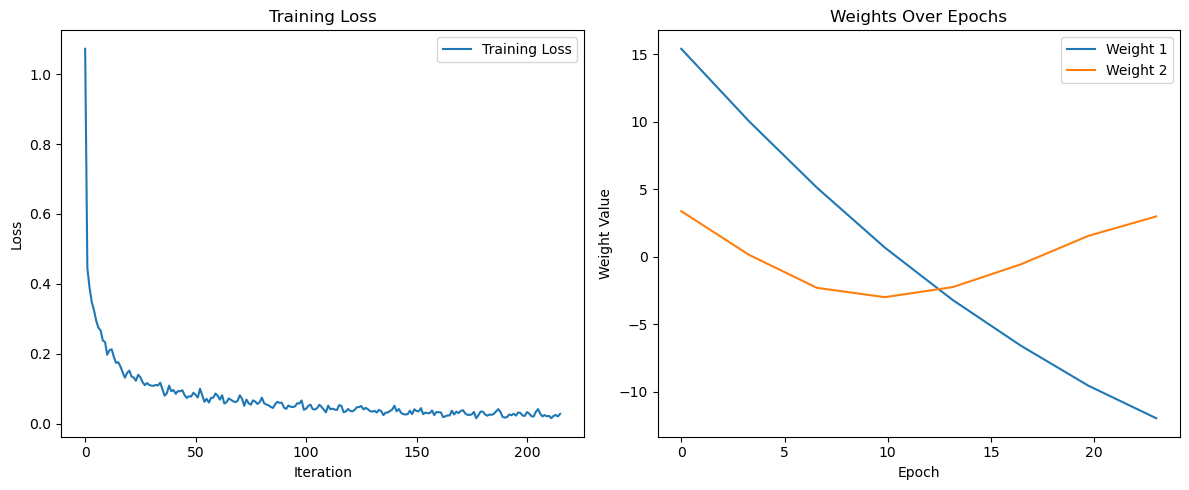

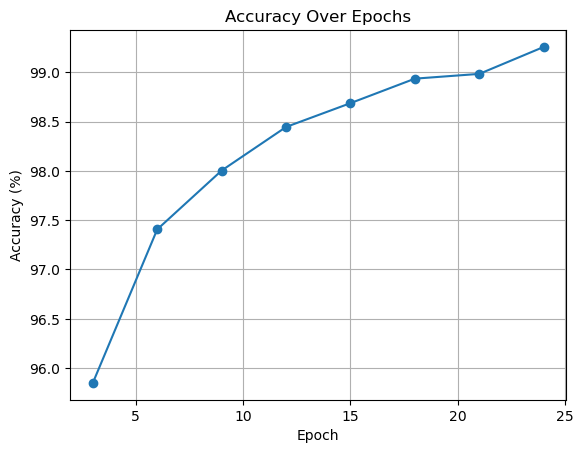

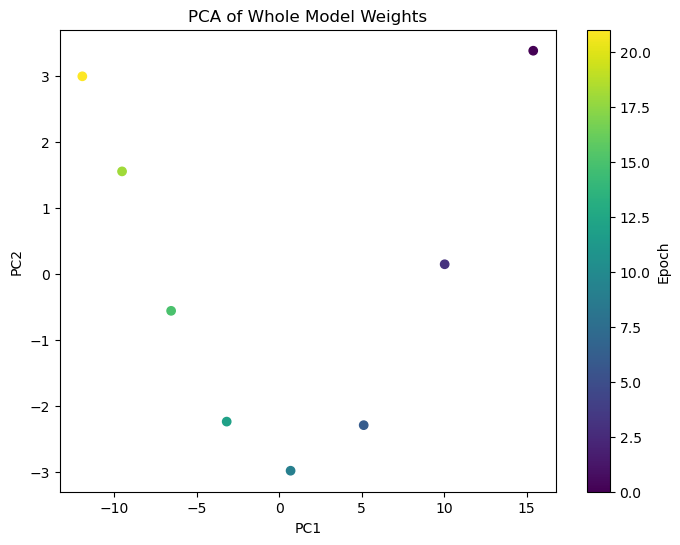

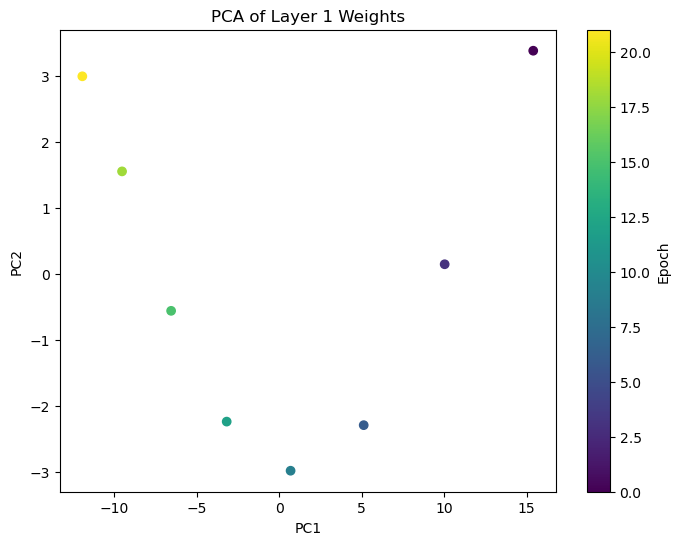

In [16]:
# Main function
def main():
    # Parameters
    num_epochs = 24
    train_batch_size = 64
    learning_rate = 0.001
    status_interval = 100
    collect_interval = 3

    # Check if GPU is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load data
    train_loader, _ = load_data(train_batch_size=train_batch_size)

    # Initialize model, optimizer, and loss function
    model = DNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    # Train model
    train_losses, epoch_weights, epoch_accuracies = train_model(model, train_loader, optimizer, loss_func, num_epochs=num_epochs,
                                               status_interval=status_interval, collect_interval=collect_interval)

    # Reduce dimensionality of weights using PCA
    pca = PCA(n_components=2)
    pca_weights = pca.fit_transform(np.array(epoch_weights))

    # Visualize optimization process
    visualize_optimization(train_losses, pca_weights, epoch_accuracies, num_epochs, collect_interval)

if __name__ == "__main__":
    main()

Epoch: 100, Loss: 0.0518, Grad Norm: 0.04283317004643753
Epoch: 200, Loss: 0.0310, Grad Norm: 0.031609785029915786
Epoch: 300, Loss: 0.0158, Grad Norm: 0.020879446298280497
Epoch: 400, Loss: 0.0092, Grad Norm: 0.012215407455439782
Epoch: 500, Loss: 0.0066, Grad Norm: 0.00788892050306404
Convergence reached for loss: 0.0053566996939480305


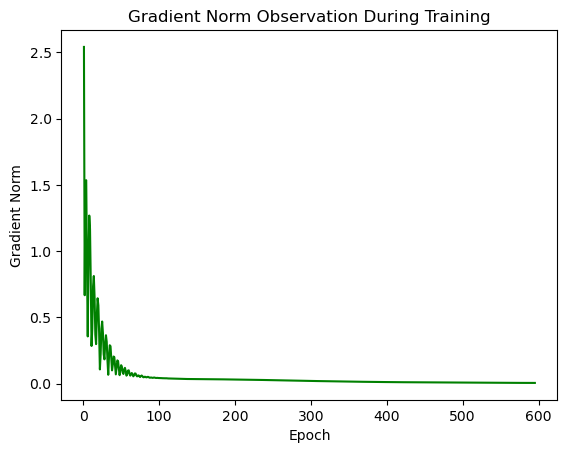

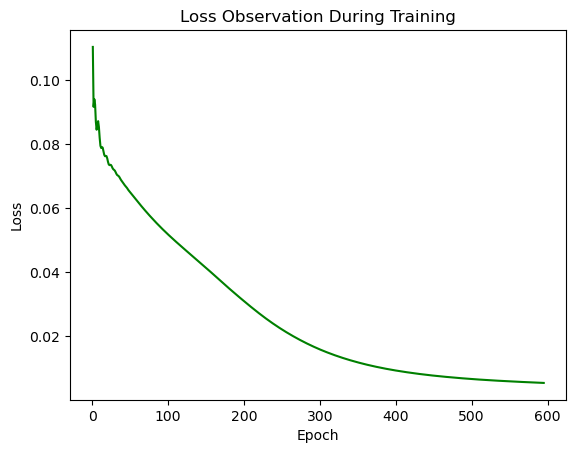

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1) 

# Generating data
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)
y = (torch.sin(5 * np.pi * x)) / (5 * np.pi * x)

# Define the neural network model
class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.fc1 = nn.Linear(1, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train(model, x, y, optimizer, loss_func, max_epoch=2500, convergence_threshold=1.0e-05):
    epoch_arr, loss_arr, grad_arr = [], [], []
    not_converged = True
    epoch = 0
    
    while not_converged:
        epoch += 1
        prediction = model(x)
        loss = loss_func(prediction, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_arr.append(epoch)
        loss_arr.append(loss.item())

        grad_norm = calculate_gradient_norm(model)
        grad_arr.append(grad_norm)
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Grad Norm: {grad_norm}')
        
        if epoch == max_epoch:
            print("Max Epoch Reached")
            not_converged = False
        elif epoch > 5 and abs(loss_arr[-3] - loss_arr[-2]) < convergence_threshold and abs(loss_arr[-2] - loss_arr[-1]) < convergence_threshold:
            print("Convergence reached for loss:", loss_arr[-1])
            not_converged = False
                
    return epoch_arr, loss_arr, grad_arr

# Function to calculate gradient norm
def calculate_gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
    grad_norm = grad_all ** 0.5
    return grad_norm

# Initialize the model and optimizer
m1 = M1()
optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3, weight_decay=1e-4)
loss_func = nn.MSELoss()

# Train the model
M1epoch_arr, M1loss_arr, M1gradArr = train(m1, x, y, optimizer, loss_func)

# Plot gradient norm observation during training
plt.plot(M1epoch_arr, M1gradArr, color="green")
plt.title('Gradient Norm Observation During Training')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.savefig('GradientNorm.pdf', dpi=700, bbox_inches='tight')
plt.show()

# Plot loss observation during training
plt.plot(M1epoch_arr, M1loss_arr, color="green")
plt.title('Loss Observation During Training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('Loss.pdf', dpi=700, bbox_inches='tight')
plt.show()


In [7]:
#!pip install autograd_lib
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib
from torch.utils.data import DataLoader, TensorDataset

In [8]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

In [9]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
    

In [10]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)
    
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.symeig(h).eigenvalues 
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 

    return ratio_mean

In [11]:
def get_norm_minimal_ratio(model,criterion):

    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [12]:
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm


def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        prediction = model(X)
        loss = criterion(prediction, Y)
        loss.backward()
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model,criterion)
        optimizer.step() 
        optimizer.zero_grad()
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
    return history,grad_norm_per_epoch,model

In [13]:
num_of_rows = 300
lr = 0.0004
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2500
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
filename = criterion_name+ optimizer_name+".png"
grad_norm_name = "_grad_norm_name1_2.png"
result_folder_name = "result3/"

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2000
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"
input_size=1
output_size=1
model= MathRegressor()

In [15]:
autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)           

In [16]:
result_1 = evaluate(model,criterion,data_loader)
filename = criterion_name+ optimizer_name+".png"

In [17]:
train,target = X,Y

In [18]:
class M1(torch.nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.hidden1 = torch.nn.Linear(1, 5)   # hidden layer
        self.hidden2 = torch.nn.Linear(5, 10)
        self.hidden3 = torch.nn.Linear (10, 10)
        self.hidden4 = torch.nn.Linear (10, 10)
        self.hidden5 = torch.nn.Linear (10, 10)
        self.hidden6 = torch.nn.Linear (10, 10)
        self.hidden7 = torch.nn.Linear (10,5)
        self.predict = torch.nn.Linear(5, 1)   # output layer
        #self.activation = nn.LeakyReLU()
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))      # activation function for hidden layer
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = F.leaky_relu(self.hidden5(x))
        x = F.leaky_relu(self.hidden6(x))
        x = F.leaky_relu(self.hidden7(x))
        x = self.predict(x)                    # linear output
        return x

model_1 = M1()     # define the network


In [19]:
history_1,grad_norm_1,model  = fit(num_epochs, lr, model, data_loader, criterion,optimizer)

gradient norm: 1.3929941803216934, minimum ratio: 0.69921875
Epoch [0], val_loss: 0.1756
gradient norm: 1.4726851042360067, minimum ratio: 0.72265625
Epoch [1], val_loss: 0.1853
gradient norm: 1.5524260513484478, minimum ratio: 0.7265625
Epoch [2], val_loss: 0.1955
gradient norm: 1.632217450067401, minimum ratio: 0.7421875
Epoch [3], val_loss: 0.2062
gradient norm: 1.7120597381144762, minimum ratio: 0.71484375
Epoch [4], val_loss: 0.2174
gradient norm: 1.7919560857117176, minimum ratio: 0.734375
Epoch [5], val_loss: 0.2292
gradient norm: 1.8718904741108418, minimum ratio: 0.70703125
Epoch [6], val_loss: 0.2415
gradient norm: 1.9518781788647175, minimum ratio: 0.71875
Epoch [7], val_loss: 0.2543
gradient norm: 2.0319058056920767, minimum ratio: 0.70703125
Epoch [8], val_loss: 0.2677
gradient norm: 2.1120048258453608, minimum ratio: 0.73046875
Epoch [9], val_loss: 0.2815
gradient norm: 2.1921711321920156, minimum ratio: 0.7421875
Epoch [10], val_loss: 0.2959
gradient norm: 2.272383091971

In [20]:
grad_norm_1

{0: {'grad_norm': 1.3929941803216934, 'ratio': 0.69921875},
 1: {'grad_norm': 1.4726851042360067, 'ratio': 0.72265625},
 2: {'grad_norm': 1.5524260513484478, 'ratio': 0.7265625},
 3: {'grad_norm': 1.632217450067401, 'ratio': 0.7421875},
 4: {'grad_norm': 1.7120597381144762, 'ratio': 0.71484375},
 5: {'grad_norm': 1.7919560857117176, 'ratio': 0.734375},
 6: {'grad_norm': 1.8718904741108418, 'ratio': 0.70703125},
 7: {'grad_norm': 1.9518781788647175, 'ratio': 0.71875},
 8: {'grad_norm': 2.0319058056920767, 'ratio': 0.70703125},
 9: {'grad_norm': 2.1120048258453608, 'ratio': 0.73046875},
 10: {'grad_norm': 2.1921711321920156, 'ratio': 0.7421875},
 11: {'grad_norm': 2.272383091971278, 'ratio': 0.7265625},
 12: {'grad_norm': 2.3526625484228134, 'ratio': 0.71875},
 13: {'grad_norm': 2.432971477508545, 'ratio': 0.7265625},
 14: {'grad_norm': 2.5133456364274025, 'ratio': 0.7421875},
 15: {'grad_norm': 2.593792147934437, 'ratio': 0.7109375},
 16: {'grad_norm': 2.6742691583931446, 'ratio': 0.738

In [22]:
val_losses_1 = [r['val_loss'] for r in history_1]
len(val_losses_1)

2000

In [23]:
minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]

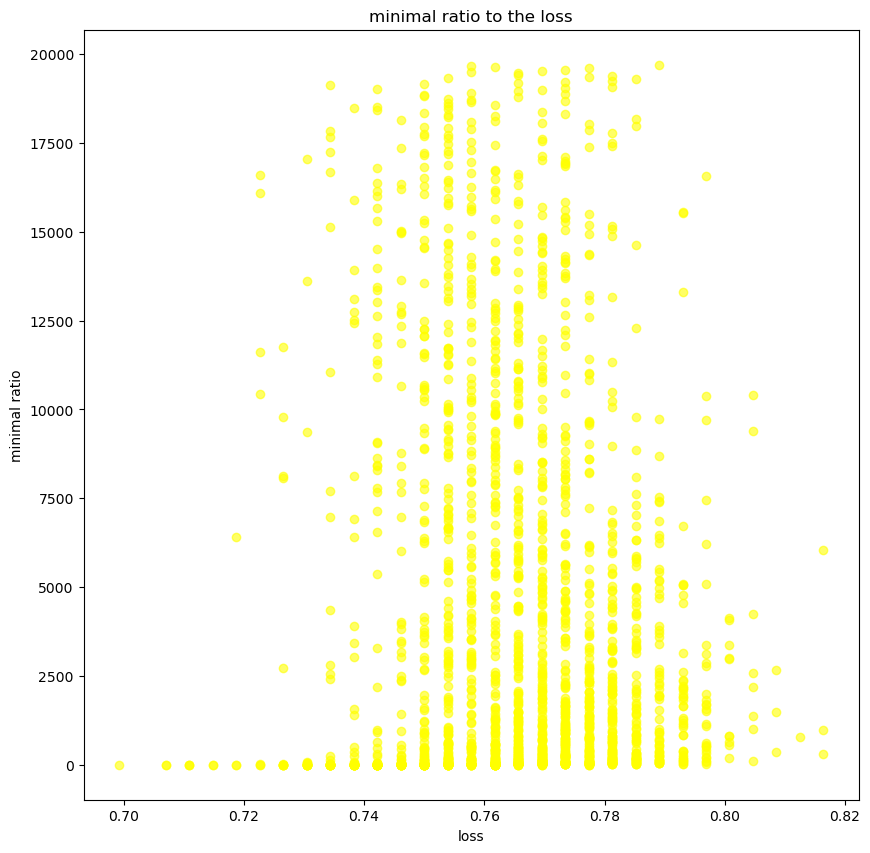

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(minimal_ratio_eps,val_losses_1,color = 'yellow', alpha = 0.6)
plt.xlabel('loss')
plt.ylabel('minimal ratio')
plt.title('minimal ratio to the loss');
plt.plot()
plt.savefig('Zero_Grad.pdf',
            dpi=700,
            bbox_inches='tight')
plt.savefig("loss_vs_minimal ratio.png")